# Praca domowa nr 2

## Wczytanie danych

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("allegro-api-transactions.csv")

In [2]:
df.head(3)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
lp                        420020 non-null int64
date                      420020 non-null object
item_id                   420020 non-null int64
categories                420020 non-null object
pay_option_on_delivery    420020 non-null int64
pay_option_transfer       420020 non-null int64
seller                    420020 non-null object
price                     420020 non-null float64
it_is_allegro_standard    420020 non-null int64
it_quantity               420020 non-null int64
it_is_brand_zone          420020 non-null int64
it_seller_rating          420020 non-null int64
it_location               420020 non-null object
main_category             420020 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 44.9+ MB


## Kodowanie zmiennych kategorycznych

### Target encoding własny
Zanim pogrupujemy możemy zrobić mały porządek niewielkim nakładem pracy w kolumnie it_location, zmieniając wszystkie litery na małe i dopiero wtedy grupując.

In [4]:
df["it_location"] = df["it_location"].str.lower()
df1 = df.copy()
df1["it_location"] = df1["it_location"].map(df1.groupby("it_location")["price"].mean())
df1.head(3)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,84.132898,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,84.132898,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,64.883187,Dom i Ogród


Możemy poprawić algorytm dodając wygładzenie Laplace'a, biorąc pod uwagę srednią, które jest dane wzorem

$$\mu=\frac{n \times \bar{x}+m \times w}{n+m}$$
gdzie:
- $\mu$ jest średnią jaką chcemy obliczyć (tą którą uzyjemy do zastąpienia wartości kategorycznych)
- $n$ - ilość wartości jaką rozpatrujemy
- $\bar{x}$ - średnia oczekiwana - ta ktora liczylismy wczesniej
- $m$ - waga sredniej wszystkich obserwacji (0 - w ogole nie bierzemy pod uwage i liczymy zwykla srednia, a im wyzsza tym bardziej uzalezniamy od sredniej reszty)
- $w$ - średnia wszystkich obserwacji targetu

In [5]:
def laplace_smooth_mean(df, by, target, m):
    # Srednia po wszystkich targetach
    w = df[target].mean()
    
    # Policzmy licznosc kazdej z grup i srednia
    agg = df.groupby(by)[target].agg(["count","mean"])
    counts = agg["count"]
    means = agg["mean"]
    
    # policzmy wygladzona srednia
    smooth = (counts * means + m * w) / (counts + m)
    
    # zwracamy wektor zmapowanych wartosci smooth
    return df[by].map(smooth)
    

In [6]:
laplace_smooth_mean(df, by = "it_location", target = "price", m = 0.001 * df.shape[0])

0          84.020918
1          84.020918
2          68.090616
3          68.599239
4          73.905633
             ...    
420015     57.334220
420016     66.628496
420017     73.545848
420018    103.262571
420019     77.382460
Name: it_location, Length: 420020, dtype: float64

Dzięki temu uzyskaliśmy wyniki bardziej wygłądzone, czyli w pewnym stopniu rozwiązuje nam się problem przypadku, w którym mielibysmy niewiele rekordó dla danej miejscowości, ale nie do konca bylibysmy w stanie przewidziec (bo probka jest za mala), ze faktycznie nie ma to zadnego znaczenia

### Target encoding z pakietu category_encoders

In [7]:
import category_encoders
df2 = df.copy()

te = category_encoders.target_encoder.TargetEncoder(df2, cols = "it_location")
encoded_te = te.fit_transform(X = df2, y = df2["price"])

encoded_te.head(3)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,84.132898,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,84.132898,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,64.883187,Dom i Ogród


### Target-encoding, a one-hot encoding
W tym przypadku dużo więcej sensu ma target-encoding, ponieważ mamy do czynienia z dużą ilością kategorii w zmiennej kategroycznej "it_location". Użycie one-hot encoding spowodowałoby utworzenie wielu dodatkowych kolumn i mógłbym sie pojawić problem z pamięcią dla takiej ramki danych.

### One-hot encoding main_category

In [8]:
oh = category_encoders.one_hot.OneHotEncoder(cols = "main_category")
encoded_oh = oh.fit_transform(X = df, y = df["price"])
encoded_oh.head(3)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,...,main_category_18,main_category_19,main_category_20,main_category_21,main_category_22,main_category_23,main_category_24,main_category_25,main_category_26,main_category_27
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,...,0,0,0,0,0,0,0,0,0,0
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,...,0,0,0,0,0,0,0,0,0,0
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,...,0,0,0,0,0,0,0,0,0,0


### Binary encoding main_category

In [9]:
bi = category_encoders.binary.BinaryEncoder(cols = "main_category")
encoded_bi = bi.fit_transform(X = df, y = df["price"])
encoded_bi.head(3)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,warszawa,0,0,0,0,0,1
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,warszawa,0,0,0,0,1,0
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,leszno,0,0,0,0,1,1


### James-Stein main_category

In [10]:
jst = category_encoders.james_stein.JamesSteinEncoder(cols = ["main_category"])
encoded_jst = jst.fit_transform(X = df, y = df["price"])
encoded_jst.head(3)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,warszawa,101.735793
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,warszawa,75.894257
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,leszno,73.179117


###  Wnioski z 3 powyższych sposobów encodingu
#### One-hot encoding
Ta metoda wprowadza dużą ilosć dodatkowych kolumn, co może się przekładać na spowolnienei algorytmu uczącego, zwłaszcza, jeżeli mamy dużo kategorii wewnątrz zmiennej kategorycznej. Jednak jest bardzo popularna, ponieważ nie pozbywamy się, ani nie dodajemy żadnych nowych informacji, czyli nie robimy założeń (tak jak np. w target encodingu), które mogłyby być błędne, gdyby zbiór uczący był niefortunną próbką.
#### Binary encoding
Zamysł taki sam jak w one-hot, z tym, ze pozbywamy się problemu nadmiernej iosći dodatkowych kolumn, ponieważ liczba jest przedstawiona w postaci binarnej za pomocą dodatkowych kolumn. Czyli w przypadku n kategorii, potrzebujemy $\log_2 n$ dodatkowych kolumn
#### James-stein encoding
Pomysł bardzo podobny co w przypadku target-encodingu z tym, ze ten sposób jest neico abrdziej odporny na przykłady, gdzie mamy mała próbkę. Bo jest pewna różnica przy zakłądaniu prawodpobieństwa 4% przy 4000 obserwacjach, a przy 50. Działa trochę podobnie jak wygładzanie przy Target encodingu - bierze pod uwagę średnia nei tylko dla danej grupy, ale też dla wszystkich obserwacji. Więcej o metodzie tu:
https://kiwidamien.github.io/james-stein-encoder.html




## Uzupełnianie braków

In [11]:
df_num = df[["price","it_seller_rating","it_quantity"]]
df_num.head(3)

,price,it_seller_rating,it_quantity
0,59.99,50177,997
1,4.90,12428,9288
2,109.90,7389,895


### Nearest neighbours imputation

In [12]:
import random
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error

# wygenerowanie wektora z wierszami, w ktorych usuniemy wartosci
to_delete = random.sample(range(df_num.shape[0]), math.ceil(0.1 * df_num.shape[0]))

# zamienianie wartosci na nan
df_num_deleted = df_num.copy()
df_num_deleted.loc[to_delete,"it_seller_rating"] = np.nan

#inputacja
imp = IterativeImputer(max_iter=20)
df_num_imp = pd.DataFrame(imp.fit_transform(df_num_deleted))

#RMSE
math.sqrt(mean_squared_error(df_num, df_num_imp))

6799.3229574871975

Teraz zróbmy to w petli dla 10 wyników

In [13]:
scores = []
for i in range(10):
    to_delete = random.sample(range(df_num.shape[0]), math.ceil(0.1 * df_num.shape[0]))

    # zamienianie wartosci na nan
    df_num_deleted = df_num.copy()
    df_num_deleted.loc[to_delete,"it_seller_rating"] = np.nan

    #inputacja
    imp = IterativeImputer(max_iter=20)
    df_num_imp = pd.DataFrame(imp.fit_transform(df_num_deleted))

    #RMSE
    scores.append(math.sqrt(mean_squared_error(df_num, df_num_imp)))
print(f'Std = {np.std(scores)}, Mean = {np.mean(scores)}')

Std = 83.47994345935093, Mean = 6684.195442713943


To samo dla 2 zmiennych

In [14]:
scores2 = []
for i in range(10):
    to_delete1 = random.sample(range(df_num.shape[0]), math.ceil(0.1 * df_num.shape[0]))
    to_delete2 = random.sample(range(df_num.shape[0]), math.ceil(0.1 * df_num.shape[0]))
    
    # zamienianie wartosci na nan
    df_num_deleted = df_num.copy()
    df_num_deleted.loc[to_delete1,"it_seller_rating"] = np.nan
    df_num_deleted.loc[to_delete2,"it_quantity"] = np.nan

    #inputacja
    imp = IterativeImputer(max_iter=20)
    df_num_imp = pd.DataFrame(imp.fit_transform(df_num_deleted))

    #RMSE
    scores2.append(math.sqrt(mean_squared_error(df_num, df_num_imp)))
print(f'Std = {np.std(scores2)}, Mean = {np.mean(scores2)}')

Std = 40.546981605983525, Mean = 7918.0069336832485


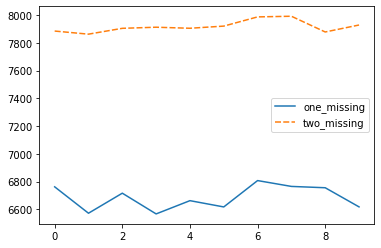

In [16]:
import seaborn as sns

score = pd.DataFrame({"one_missing":scores,"two_missing":scores2})
sns.lineplot(data = score)

Biorąc pod uwagę, że mieliśmy 42 tysiące usunietych wartości z wierszy to RMSE na poziomie 7000 jest błedem stosunkowo niewielkim. To mneij więcej tyle, ile wynsiłoby RMSE, jeżeli każda wyznaczona przez nas wartość była wyznaczona z błedem +-1. Zgodnie z przewidywaniami RMSE w przypadku operacji z usunięciem w obu kolumnach 10% wartości okazuje się byc większe. Jednak nie jest większe dwukrotnie tak jak mogłoby się wydawać, zatem widać, ze ta metoda sprawdza się nawet w przypadku braków w wiekszej ilsoci kolumn.